Neural Network from scratch (ReLU)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tr = pd.read_csv("fashion-mnist_train.csv")
te = pd.read_csv("fashion-mnist_test.csv")

In [3]:
X_train = tr.drop('label', axis=1).values
y_train = tr['label'].values
X_test = te.drop('label', axis=1).values
y_test = te['label'].values

In [4]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [5]:
def one_hot_encode(y, num_classes):
    one_hot = np.zeros((y.size, num_classes))
    one_hot[np.arange(y.size), y] = 1
    return one_hot

In [6]:
num_classes = 10
y_train = one_hot_encode(y_train, num_classes)
y_test = one_hot_encode(y_test, num_classes)

In [7]:
def train_val_split(X, y, val_size=0.2):
    num_samples = X.shape[0]
    num_val_samples = int(num_samples * val_size)
    
    
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    
    
    X_train = X[indices[:-num_val_samples]]
    y_train = y[indices[:-num_val_samples]]
    X_val = X[indices[-num_val_samples:]]
    y_val = y[indices[-num_val_samples:]]
    
    return X_train, X_val, y_train, y_val

In [8]:
X_train, X_val, y_train, y_val = train_val_split(X_train, y_train, val_size=0.2)

In [9]:
class SimpleNN:
    def __init__(self, input_size, hidden_size, output_size):
        # Weight initialization without Xavier
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01  # Small random values
        self.b1 = np.zeros(hidden_size)
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01  # Small random values
        self.b2 = np.zeros(output_size)

        self.learning_rate = 0.001  # Learning Rate
        self.loss_history = []  # To store loss values for plotting

    def relu(self, z):
        return np.maximum(0, z)  # ReLU activation function

    def relu_derivative(self, z):
        return (z > 0).astype(float)  # Derivative of ReLU

    def softmax(self, z):
        exp_scores = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.relu(self.z1)  # ReLU activation
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.softmax(self.z2)  # Softmax for output layer
        return self.a2

    def compute_loss(self, y_pred, y_true):
        n_samples = y_true.shape[0]
        epsilon = 1e-15
        log_likelihood = -np.log(y_pred[range(n_samples), np.argmax(y_true, axis=1)] + epsilon)
        loss = np.sum(log_likelihood) / n_samples
        return loss

    def backprop(self, X, y):
        n_samples = X.shape[0]
        delta2 = self.a2 - y
        dW2 = np.dot(self.a1.T, delta2)
        db2 = np.sum(delta2, axis=0)
        
        delta1 = np.dot(delta2, self.W2.T) * self.relu_derivative(self.a1)  
        dW1 = np.dot(X.T, delta1)
        db1 = np.sum(delta1, axis=0)

        
        self.W1 -= self.learning_rate * dW1  
        self.b1 -= self.learning_rate * db1  
        self.W2 -= self.learning_rate * dW2  
        self.b2 -= self.learning_rate * db2  

    def train(self, X, y, X_val, y_val, epochs=100, batch_size=32):
        num_samples = X.shape[0]
        best_loss = float('inf')
        patience = 10  
        no_improvement_count = 0

        for epoch in range(epochs):
            for i in range(0, num_samples, batch_size):
                X_batch = X[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                y_pred = self.forward(X_batch)
                loss = self.compute_loss(y_pred, y_batch)
                self.backprop(X_batch, y_batch)

            
            self.loss_history.append(loss)

            
            train_pred = self.predict(X)  
            train_acc = accuracy(train_pred, y)  
            
            
            val_pred = self.predict(X_val) 
            val_acc = accuracy(val_pred, y_val)  

            if loss < best_loss:
                best_loss = loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            if no_improvement_count > patience:
                print("Early stopping")
                break

            if epoch % 10 == 0 or epoch == epochs - 1: 
                print(f'Epoch {epoch}, Loss: {loss}, Training Accuracy: {train_acc * 100:.2f}%, Validation Accuracy: {val_acc * 100:.2f}%')

        print(f'Final Validation Accuracy: {val_acc * 100:.2f}%') 

    def predict(self, X):
        y_pred = self.forward(X)
        return np.argmax(y_pred, axis=1)


In [10]:
def accuracy(y_pred, y_true):
    correct = np.sum(y_pred == np.argmax(y_true, axis=1))
    total = y_true.shape[0]
    return correct / total

In [11]:
def precision(y_pred, y_true):
    y_true_labels = np.argmax(y_true, axis=1)
    true_positives = np.sum((y_pred == y_true_labels) & (y_pred == 1))
    predicted_positives = np.sum(y_pred == 1)
    return true_positives / predicted_positives if predicted_positives != 0 else 0

In [12]:
def recall(y_pred, y_true):
    y_true_labels = np.argmax(y_true, axis=1)
    true_positives = np.sum((y_pred == y_true_labels) & (y_true_labels == 1))
    actual_positives = np.sum(y_true_labels == 1)
    return true_positives / actual_positives if actual_positives != 0 else 0

In [13]:
def f1_score(y_pred, y_true):
    p = precision(y_pred,y_true)
    r= recall(y_pred,y_true)
    return (2 * (p * r)) / (p + r) if (p + r) != 0 else 0

In [14]:
def plot_confusion_matrix_from_scratch(y_true,y_pred):
    cm=np.zeros((num_classes,num_classes),dtype=int)

    for i in range(len(y_true)):
        true_label=np.argmax(y_true[i])   
        pred_label=int(y_pred[i])         
        
        cm[true_label][pred_label]+=1     
    
    plt.figure(figsize=(10 ,7))
    sns.heatmap(cm ,annot=True ,fmt='d' ,cmap='Blues' ,
                xticklabels=[str(i) for i in range(num_classes)],
                yticklabels=[str(i) for i in range(num_classes)])
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [15]:
def plot_cost_vs_iterations(loss_history):
    plt.figure(figsize=(10 ,6))
    plt.plot(loss_history)
    
    plt.title('Cost vs Iterations')
    plt.xlabel('Iterations (Epochs)')
    plt.ylabel('Cost (Loss)')
    
    plt.grid()
    plt.show()

Epoch 0, Loss: 0.37537546055704357, Training Accuracy: 79.79%, Validation Accuracy: 79.53%
Epoch 10, Loss: 0.13648998762742992, Training Accuracy: 87.88%, Validation Accuracy: 86.28%
Epoch 20, Loss: 0.12168956156273622, Training Accuracy: 89.71%, Validation Accuracy: 87.23%
Epoch 30, Loss: 0.11134392678435615, Training Accuracy: 91.01%, Validation Accuracy: 87.85%
Epoch 39, Loss: 0.11596221042331745, Training Accuracy: 91.76%, Validation Accuracy: 87.92%
Final Validation Accuracy: 87.92%
Test Accuracy: 88.07%
Precision: 0.99
Recall: 0.98
F1 Score: 0.98


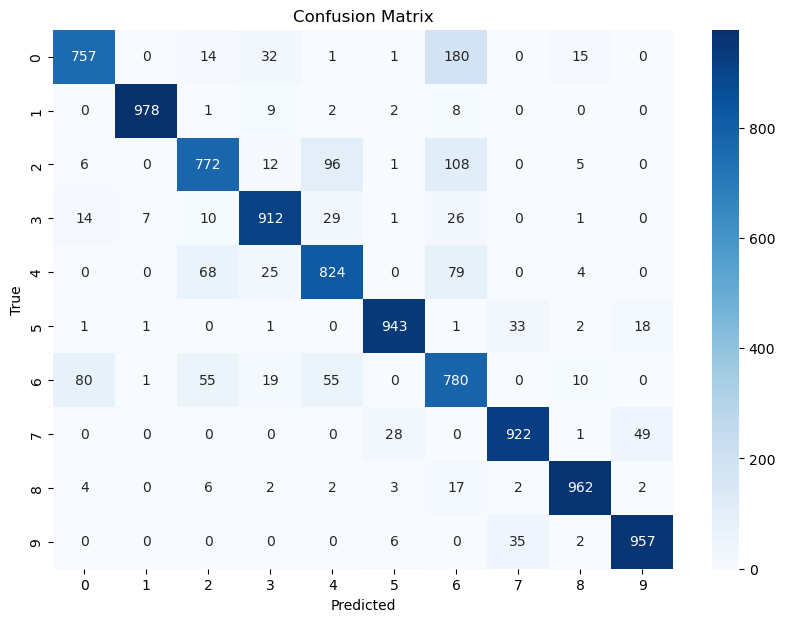

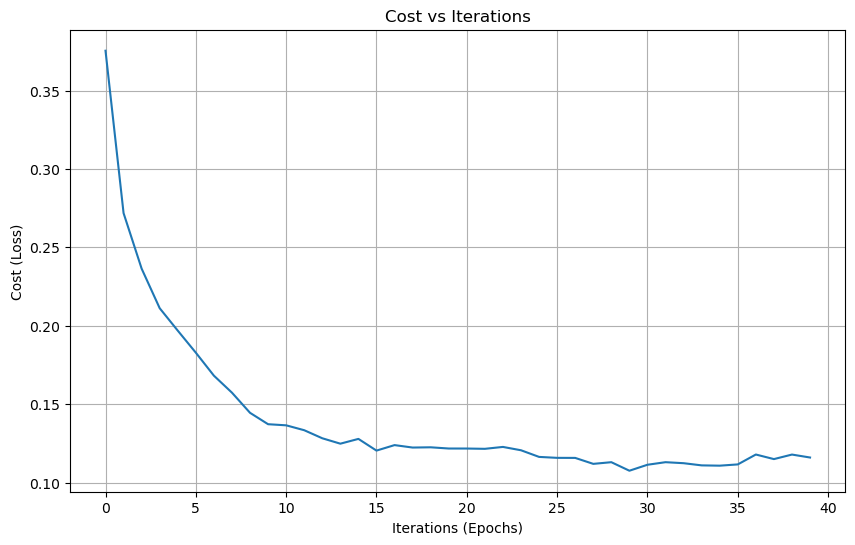

In [16]:
nn=SimpleNN(input_size=784 ,hidden_size=64 ,output_size=10)
nn.train(X_train,y_train,X_val,y_val ,epochs=40)

y_pred_test=nn.predict(X_test)
acc_test=accuracy(y_pred_test,y_test)
prec_test=precision(y_pred_test,y_test)
rec_test=recall(y_pred_test,y_test)
f1_test=f1_score(y_pred_test,y_test)

print(f'Test Accuracy: {acc_test *100:.2f}%')
print(f'Precision: {prec_test:.2f}')
print(f'Recall: {rec_test:.2f}')
print(f'F1 Score: {f1_test:.2f}')

plot_confusion_matrix_from_scratch(y_test,y_pred_test)           
plot_cost_vs_iterations(nn.loss_history)